# Synthetic data demo

In [ ]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.datasets import simulation_loaders
from neuraldistributions.models.flowfa import density_estimator
from neuraldistributions.trainers import density_estimator_trainer
from neuraldistributions.utility import get_loglikelihood
from neuraldistributions.models import transforms

random_seed = 2
device = 'cuda'

In [2]:
def normalize(dd):
    dd = dd - dd.min()
    return dd / dd.max()

---

## Generate synthetic data

In [3]:
all_transforms = ['identity', 'sqrt', 'anscombe'] + [f'example{i+1}' for i in range(10)]

### Get the range in transformed space

In [4]:
y = np.linspace(0, 10, 1000) + 1e-12

for t in all_transforms:
    x = getattr(transforms, t)(numpy=True)(y)
    print(t, ":",  "{:.2f}".format(x.min()), "~", "{:.2f}".format(x.max()))

identity : 0.00 ~ 10.00
sqrt : 0.00 ~ 3.16
anscombe : 1.22 ~ 6.44
example1 : 0.00 ~ 3.15
example2 : 0.00 ~ 3.21
example3 : 0.08 ~ 3.21
example4 : 0.00 ~ 4.70
example5 : 0.00 ~ 4.71
example6 : 0.00 ~ 4.74
example7 : 0.11 ~ 4.75
example8 : 0.00 ~ 6.41
example9 : 0.00 ~ 6.46
example10 : 0.15 ~ 6.47


In [5]:
sigma_dependent_mean_shift_scale = {
    "identity": 1.,
    "sqrt": 3.,
    "anscombe": 2.,
    "example1": 1.5,
    "example2": 3.,
    "example3": 3.,
    "example4": 1.,
    "example5": 3.,
    "example6": 3.,
    "example7": 3.,
    "example8": 1.,
    "example9": 3.,
    "example10": 3.,
}

In [6]:
np.random.seed(42)

n_neurons = 100
d_latent = 4
sample_transform = "example10"

psi_diag = np.random.uniform(0.2, .5, size=n_neurons)
C = np.random.uniform(0.2, .7, size=(d_latent, n_neurons))
C = C * np.array(
    [
        [1.5] * 20 + [0.2] * 30 + [0.2] * 20 + [0.2] * 30,
        [0.2] * 20 + [1.5] * 30 + [0.2] * 20 + [0.2] * 30,
        [0.2] * 20 + [0.2] * 30 + [1.5] * 20 + [0.2] * 30,
        [0.2] * 20 + [0.2] * 30 + [0.2] * 20 + [1.5] * 30,
    ]
)
C = C * .1

psi_diag = (psi_diag * .2) ** 2
sigma = C.T @ C + np.diag(psi_diag)

y = np.linspace(0, 10, 1000) + 1e-12
x = getattr(transforms, sample_transform)(numpy=True)(y)

mean = np.random.uniform(x.min() + sigma_dependent_mean_shift_scale[sample_transform] * np.sqrt(sigma).max(), x.max(), size=n_neurons)

print("{}, {}, {}".format(x.min(), sigma_dependent_mean_shift_scale[sample_transform], np.sqrt(sigma).max()))

0.1535271830298079, 3.0, 0.1386221901171061


In [7]:
simulation_fn="neuraldistributions.datasets.simulation.gaussian"
simulation_config={"n_samples": 5000, 
                   "mean": mean, 
                   "C": C, 
                   "psi_diag": psi_diag, 
                   "transform": sample_transform}

In [8]:
dataloaders = simulation_loaders(random_seed, 64, simulation_fn=simulation_fn, simulation_config=simulation_config)
samples = np.concatenate([b[0].cpu().data.numpy() for b in dataloaders['train']])

## Initialize flow-based density estimator

In [9]:
model = density_estimator(dataloaders, random_seed, transform='learned2', d_latent=d_latent, device='cuda')

## Train the model

In [10]:
out = density_estimator_trainer(model, dataloaders, random_seed, epochs=500, lr=5e-3)

Epoch 100/500 | loss: -344.89:  20%|██        | 100/500 [01:30<06:00,  1.11it/s]

Epoch   100: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..
Applying changes..


Epoch 146/500 | loss: -376.13:  29%|██▉       | 146/500 [02:16<05:50,  1.01it/s]

Epoch   146: reducing learning rate of group 0 to 4.5000e-04.
Retrieve best model..


Epoch 168/500 | loss: -376.68:  34%|███▎      | 168/500 [02:37<05:28,  1.01it/s]

Epoch   168: reducing learning rate of group 0 to 1.3500e-04.
Retrieve best model..


Epoch 187/500 | loss: -376.62:  37%|███▋      | 187/500 [02:56<05:09,  1.01it/s]

Epoch   187: reducing learning rate of group 0 to 4.0500e-05.
Retrieve best model..


Epoch 207/500 | loss: -376.68:  41%|████▏     | 207/500 [03:16<04:48,  1.02it/s]

Epoch   207: reducing learning rate of group 0 to 1.2150e-05.
Retrieve best model..


Epoch 216/500 | loss: -376.77:  43%|████▎     | 215/500 [03:25<04:41,  1.01it/s]

Early stopping at epoch 215. Best loss: -376.936


Epoch 216/500 | loss: -376.77:  43%|████▎     | 215/500 [03:25<04:32,  1.05it/s]

Retrieve best model..


---

## Results: Comparison with ground truth model

### 1. Learned vs ground truth transformation function

In [11]:
transformation_fn = getattr(transforms, simulation_config['transform'])(numpy=False).to(device)

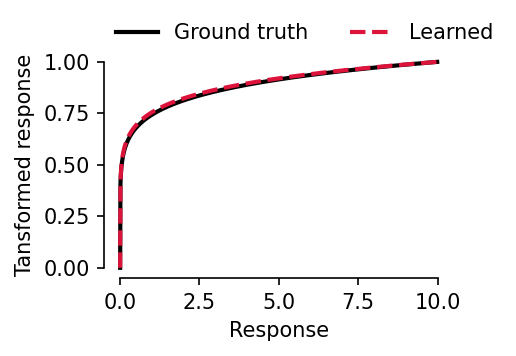

In [12]:
fig_name = f"Anscombe vs learned transformation"

y = torch.arange(0, 10, .01).to(device)[:, None] + 1e-12
outl = normalize(model.flow(y)[0])
outa = normalize(transformation_fn(y)[0]).cpu().data.numpy()

fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
ax.plot(y.cpu().data.numpy(), outa, lw=2, c='k', label="Ground truth")
ax.plot(y.cpu().data.numpy(), outl.cpu().data.numpy(), lw=2, c='crimson', label="Learned", ls='--')

ax.set(xlabel="Response", ylabel="Tansformed response")
ax.legend(loc=(.01, 1), ncol=2, frameon=False)
sns.despine(trim=True)

### 2. Learned vs ground truth mean and covariance

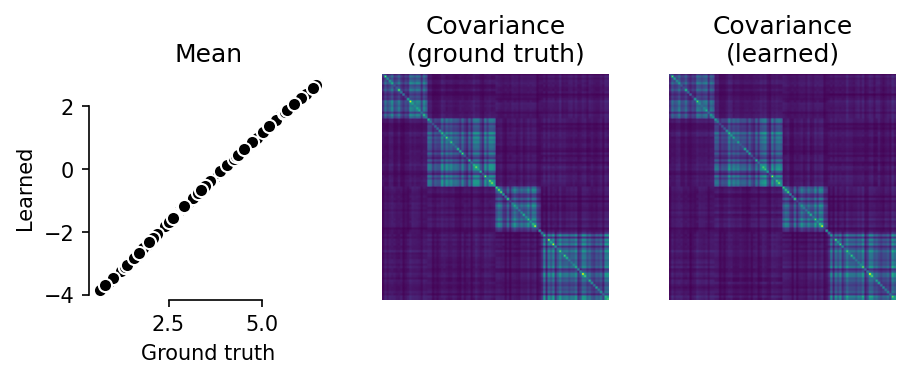

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2), dpi=150)

ax1.scatter(simulation_config["mean"], model.dist.mu.cpu().data.numpy(), s=40, c='k', ec='w');
ax1.set(xlabel="Ground truth", ylabel="Learned", title="Mean")
sns.despine(trim=True, ax=ax1)

C = np.array(simulation_config['C'])
psi_diag = np.array(simulation_config['psi_diag'])
gt_sigma = C.T @ C + np.diag(psi_diag)
ax2.imshow(gt_sigma, vmin=gt_sigma.min(), vmax=gt_sigma.max());
ax2.axis('off')
ax2.set(title="Covariance\n(ground truth)")

learned_sigma = (model.dist.C.T @ model.dist.C + torch.diag(model.dist.psi_diag)).cpu().data.numpy()
ax3.imshow(learned_sigma)
ax3.axis('off')
ax3.set(title="Covariance\n(learned)");

### 3. KL divergence between learned and ground truth model

#### Ground truth model

In [14]:
gt_model = density_estimator(dataloaders, random_seed, transform=simulation_config['transform'], d_latent=d_latent, device='cuda')
gt_model.dist.mu.data.copy_(torch.from_numpy(simulation_config['mean'].astype(np.float32)).to(model.dist.mu.device))
gt_model.dist.logpsi_diag.data.copy_(torch.from_numpy(np.log(simulation_config['psi_diag']).astype(np.float32)).to(model.dist.logpsi_diag.device))
gt_model.dist.C.data.copy_(torch.from_numpy(simulation_config['C'].astype(np.float32)).to(model.dist.C.device))
gt_model.eval();

In [15]:
trained_model_ll = get_loglikelihood(dataloaders['test'], model, has_datakey=False)[1][0] / np.log(2) / simulation_config['n_samples'] / n_neurons

In [16]:
gt_model_ll = get_loglikelihood(dataloaders['test'], gt_model, has_datakey=False)[1][0] / np.log(2)  / simulation_config['n_samples'] / n_neurons

In [17]:
gt_model_ll - trained_model_ll

0.0012565873806131833

---